# Predicting IBM 1-min-time series
* DO NOT TOUCH THIS UNTIL THE STRATEGY THAT THESE MODELS SUGGEST IS SIMULATED
* It is possible to get (ocationally) a signal with around 1% recall and around 80% precision using a regularized logistic regression
* If we managed to do this on many stocks we would be able to build a reasonable strategy from there.
* Still need to simulate the strategy for many stocks. It might actually work
* Do some slides to show Jake
* What if we negate the target and study NPV instead: recall improves !
* Use naive Bayes: BernoulliNB out of the box is producing nice precision-recall curves
* What if we deal with class weights in the logistic regressions? class_weight

In [1]:
cd ~/Desktop/MyProjects/moneyManager/

/Users/lduque/Desktop/myProjects/moneyManager


In [2]:
class_weight={True:1, False:1}

In [3]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.metrics import precision_recall_curve 
#from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB


from modeling.createTrainingDataSet import createTrainingDataSet
from modeling.loadTimeSeries import loadTimeSeries
from modeling.StockModel import generatePipeline
from modeling.sklearnUtilities import createTimeFeatures

pd.set_option('display.max_columns', None)

In [4]:
def plot_precision_recall_on_train_and_test(model, Xtrain, ytrain, Xtest, ytest):
    disp = plot_precision_recall_curve(model, Xtrain, ytrain)
    disp.ax_.set_xlim(0.0, 0.5);
    disp.ax_.set_ylim(0.4, 1.0);
    disp.ax_.set_title('precision - recall in train data set');


    disp = plot_precision_recall_curve(model, Xtest, ytest);
    disp.ax_.set_xlim(0.0, 0.5);
    disp.ax_.set_ylim(0.4, 1.0);
    disp.ax_.set_title('precision - recall in test data set');

In [5]:
startDay=datetime(2019,7,1)
endDay= datetime(2019,8,1)
df = createTrainingDataSet('IBM',  startDay=startDay, endDay=endDay, pastStart=10)
df = df[['consolidated', 'volume', 'target']]

In [6]:
df.head()

,consolidated,volume,target
date,,,
2019-07-01 13:31:00,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",True
2019-07-01 13:32:00,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",True
2019-07-01 13:33:00,"[nan, nan, nan, nan, nan, nan, nan, nan, 136.3...","[nan, nan, nan, nan, nan, nan, nan, nan, 86783...",True
2019-07-01 13:34:00,"[nan, nan, nan, nan, nan, nan, nan, 136.358750...","[nan, nan, nan, nan, nan, nan, nan, 86783.0, 9...",True
2019-07-01 13:35:00,"[nan, nan, nan, nan, nan, nan, 136.35875000000...","[nan, nan, nan, nan, nan, nan, 86783.0, 9634.0...",True


In [7]:
df.shape

(8400, 3)

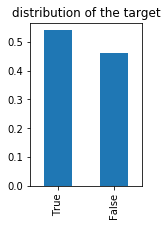

In [8]:
(df.target.value_counts()/len(df)).plot.bar(figsize=(2,3), title='distribution of the target');

In [9]:
X = df.copy()
y = X.pop('target')

In [10]:
Xtrain, ytrain = X[:len(X)//2], y[:len(X)//2] 
Xtest, ytest = X[len(X)//2:], y[len(X)//2:]

# Debugging the pipeline
* So far we have 83 features

In [11]:
pipeline = generatePipeline()
pipeline.fit(Xtrain)
XtrainTrf = pipeline.transform(Xtrain)
XtestTrf = pipeline.transform(Xtest)
XtrainTrf.shape

/Users/lduque/Desktop/myProjects/moneyManager/venv-money/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/lduque/Desktop/myProjects/moneyManager/venv-money/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/lduque/Desktop/myProjects/moneyManager/venv-money/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


(4200, 63)

In [12]:
Xtrain.head()

,consolidated,volume
date,,
2019-07-01 13:31:00,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2019-07-01 13:32:00,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2019-07-01 13:33:00,"[nan, nan, nan, nan, nan, nan, nan, nan, 136.3...","[nan, nan, nan, nan, nan, nan, nan, nan, 86783..."
2019-07-01 13:34:00,"[nan, nan, nan, nan, nan, nan, nan, 136.358750...","[nan, nan, nan, nan, nan, nan, nan, 86783.0, 9..."
2019-07-01 13:35:00,"[nan, nan, nan, nan, nan, nan, 136.35875000000...","[nan, nan, nan, nan, nan, nan, 86783.0, 9634.0..."


In [13]:
XtrainTrf.isna().sum()

consolidated_max          0
consolidated_argmax       0
consolidated_min          0
consolidated_argmin       0
consolidated_mean         0
                         ..
volumeDifference_last     0
volumeDifference_first    0
hour                      0
minute                    0
hourminute                0
Length: 63, dtype: int64

In [14]:
XtrainTrf.head()

,consolidated_max,consolidated_argmax,consolidated_min,consolidated_argmin,consolidated_mean,consolidated_std,consolidated_var,consolidated_median,consolidated_kurtosis,consolidated_skew,consolidated_numpos,consolidated_posvar,consolidated_numnan,consolidated_last,consolidated_first,volume_max,volume_argmax,volume_min,volume_argmin,volume_mean,volume_std,volume_var,volume_median,volume_kurtosis,volume_skew,volume_numpos,volume_posvar,volume_numnan,volume_last,volume_first,consolidatedDifference_max,consolidatedDifference_argmax,consolidatedDifference_min,consolidatedDifference_argmin,consolidatedDifference_mean,consolidatedDifference_std,consolidatedDifference_var,consolidatedDifference_median,consolidatedDifference_kurtosis,consolidatedDifference_skew,consolidatedDifference_numpos,consolidatedDifference_posvar,consolidatedDifference_numnan,consolidatedDifference_last,consolidatedDifference_first,volumeDifference_max,volumeDifference_argmax,volumeDifference_min,volumeDifference_argmin,volumeDifference_mean,volumeDifference_std,volumeDifference_var,volumeDifference_median,volumeDifference_kurtosis,volumeDifference_skew,volumeDifference_numpos,volumeDifference_posvar,volumeDifference_numnan,volumeDifference_last,volumeDifference_first,hour,minute,hourminute
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-07-01 13:31:00,0.375431,0.0,0.354363,0.0,0.365782,0.073582,0.006774,0.367171,0.131694,0.456492,0.0,0.000000,1.0,0.092483,0.365328,0.069322,0.0,0.090603,0.0,0.092048,0.062438,0.0057,0.085766,0.236417,0.487181,0.0,0.000000,1.0,1.000000,0.034955,0.072432,0.0,0.892707,0.0,0.371924,0.088695,0.011986,0.403424,0.171889,0.457896,0.0,0.002385,1.0,0.462239,0.462239,0.056106,0.0,0.949596,0.0,0.517968,0.070803,0.007252,0.393668,0.219371,0.508076,0.000000,0.002180,1.0,0.514813,0.51482,0.0,0.525424,0.000000
2019-07-01 13:32:00,0.375431,0.0,0.354363,0.0,0.365782,0.073582,0.006774,0.367171,0.131694,0.456492,0.1,0.001962,0.9,0.084272,0.365328,0.069322,0.0,0.090603,0.0,0.092048,0.062438,0.0057,0.085766,0.236417,0.487181,0.1,1.000000,0.9,0.109987,0.034955,0.072432,0.0,0.892707,0.0,0.371924,0.088695,0.011986,0.403424,0.171889,0.457896,0.0,0.002385,0.9,0.430452,0.462239,0.056106,0.0,0.949596,0.0,0.517968,0.070803,0.007252,0.393668,0.219371,0.508076,0.000000,0.002180,0.9,0.000000,0.51482,0.0,0.542373,0.001495
2019-07-01 13:33:00,0.375431,0.0,0.354363,0.0,0.365782,0.073582,0.006774,0.367171,0.131694,0.456492,0.2,0.076904,0.8,0.142436,0.365328,0.069322,0.0,0.090603,0.0,0.092048,0.062438,0.0057,0.085766,0.236417,0.487181,0.2,0.698774,0.8,0.385843,0.034955,0.072432,0.0,0.892707,0.0,0.371924,0.088695,0.011986,0.403424,0.171889,0.457896,0.1,0.000000,0.8,0.685766,0.462239,0.056106,0.0,0.949596,0.0,0.517968,0.070803,0.007252,0.393668,0.219371,0.508076,0.111111,0.000000,0.8,0.674333,0.51482,0.0,0.559322,0.002990
2019-07-01 13:34:00,0.375431,0.0,0.354363,0.0,0.365782,0.073582,0.006774,0.367171,0.131694,0.456492,0.3,0.284263,0.7,0.208285,0.365328,0.069322,0.0,0.090603,0.0,0.092048,0.062438,0.0057,0.085766,0.236417,0.487181,0.3,0.533708,0.7,0.397771,0.034955,0.072432,0.0,0.892707,0.0,0.371924,0.088695,0.011986,0.403424,0.171889,0.457896,0.2,0.005901,0.7,0.715327,0.462239,0.056106,0.0,0.949596,0.0,0.517968,0.070803,0.007252,0.393668,0.219371,0.508076,0.222222,0.136505,0.7,0.521679,0.51482,0.0,0.576271,0.004484
2019-07-01 13:35:00,0.375431,0.0,0.354363,0.0,0.365782,0.073582,0.006774,0.367171,0.131694,0.456492,0.4,0.413263,0.6,0.231761,0.365328,0.069322,0.0,0.090603,0.0,0.092048,0.062438,0.0057,0.085766,0.236417,0.487181,0.4,0.496600,0.6,0.179828,0.034955,0.072432,0.0,0.892707,0.0,0.371924,0.088695,0.011986,0.403424,0.171889,0.457896,0.3,0.135793,0.6,0.552339,0.462239,0.056106,0.0,0.949596,0.0,0.517968,0.070803,0.007252,0.393668,0.219371,0.508076,0.222222,0.136505,0.6,0.388722,0.51482,0.0,0.593220,0.005979


# Naive Bayes

In [15]:
clf = BernoulliNB()
clf.fit(XtrainTrf, ytrain); 

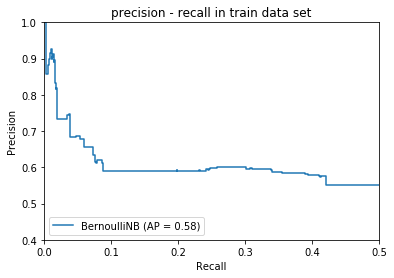

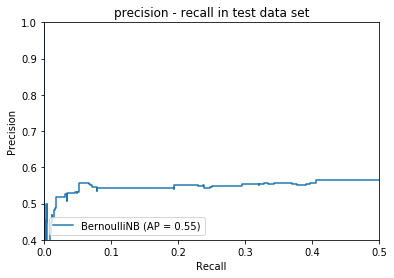

In [16]:
plot_precision_recall_on_train_and_test(clf, XtrainTrf, ytrain, XtestTrf, ytest)

In [17]:
#P = plot_precision_recall_on_train_and_test(clf, XtrainTrf, ytrain, XtestTrf, ytest)
from sklearn.metrics import precision_recall_curve
precisionTrain, recallTrain, thresholds = precision_recall_curve(ytrain, clf.predict_proba(XtrainTrf)[:,1])
thresholdsTrain = list(thresholds)+[1.0]

precisionTest, recallTest, thresholds = precision_recall_curve(ytest, clf.predict_proba(XtestTrf)[:,1])
thresholdsTest = list(thresholds)+[1.0]


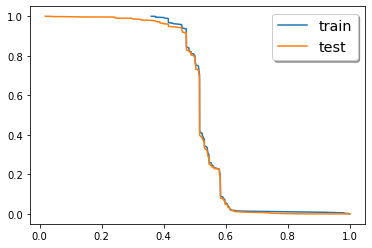

In [18]:
plt.plot(thresholdsTrain, recallTrain, label='train')
plt.plot(thresholdsTest, recallTest, label='test')
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')

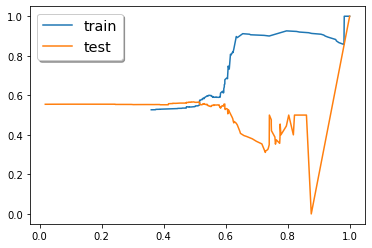

In [19]:
plt.plot(thresholdsTrain, precisionTrain, label='train')
plt.plot(thresholdsTest, precisionTest, label='test')
legend = plt.legend(loc='upper left', shadow=True, fontsize='x-large')

# No regularization
* Performance is not awesome
* Huge overfit: notice how different precision and recall curves are.

In [20]:
clf =LogisticRegression(penalty='none', max_iter=10000, class_weight=class_weight)
clf.fit(XtrainTrf, ytrain);  

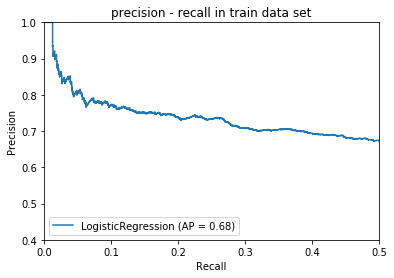

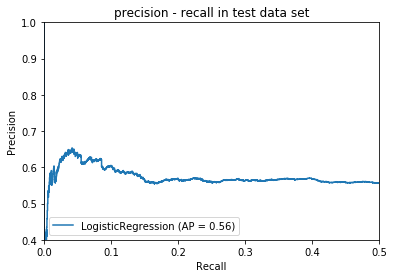

In [21]:
plot_precision_recall_on_train_and_test(clf, XtrainTrf, ytrain, XtestTrf, ytest)

In [22]:
#P = plot_precision_recall_on_train_and_test(clf, XtrainTrf, ytrain, XtestTrf, ytest)
from sklearn.metrics import precision_recall_curve
precisionTrain, recallTrain, thresholds = precision_recall_curve(ytrain, clf.predict_proba(XtrainTrf)[:,1])
thresholdsTrain = list(thresholds)+[1.0]

precisionTest, recallTest, thresholds = precision_recall_curve(ytest, clf.predict_proba(XtestTrf)[:,1])
thresholdsTest = list(thresholds)+[1.0]

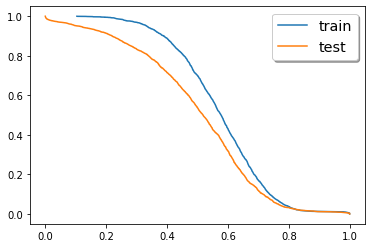

In [23]:
plt.plot(thresholdsTrain, recallTrain, label='train')
plt.plot(thresholdsTest, recallTest, label='test')
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')

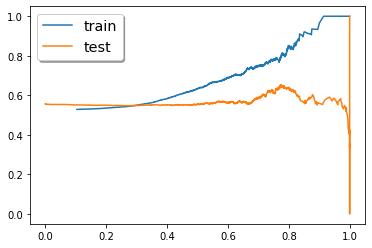

In [24]:
plt.plot(thresholdsTrain, precisionTrain, label='train')
plt.plot(thresholdsTest, precisionTest, label='test')
legend = plt.legend(loc='upper left', shadow=True, fontsize='x-large')

# L1 regularization

In [25]:
C = 10**np.linspace(-4,1,50) 
grid_parameters = {
    'C': C,
    'class_weight': [class_weight],
    'penalty':['l1']
}

clf = GridSearchCV(LogisticRegression(solver='saga',max_iter=10000, multi_class='ovr', C=C), grid_parameters, scoring='average_precision', cv=2, return_train_score=True)
clf.fit(XtrainTrf, ytrain);  
test_scores = clf.cv_results_['mean_test_score']
train_scores = clf.cv_results_['mean_train_score']
ds = pd.DataFrame({'train_scores':train_scores, 'evaluation_scores':test_scores}, index=C)

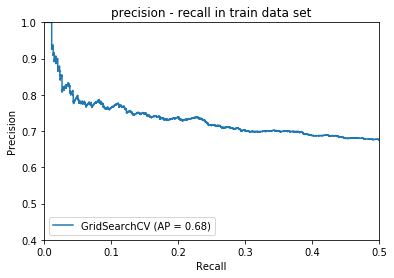

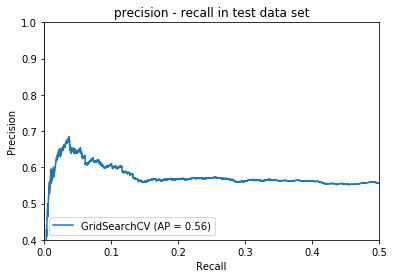

In [26]:
plot_precision_recall_on_train_and_test(clf, XtrainTrf, ytrain, XtestTrf, ytest)

0.5891248528159706
---
consolidatedDifference_posvar    12.728290
volume_mean                      10.151994
consolidatedDifference_mean       9.720724
volume_median                     6.574245
consolidated_posvar               5.449279
                                   ...    
volume_last                       0.000000
volumeDifference_mean             0.000000
consolidated_mean                 0.000000
hour                              0.000000
consolidated_max                  0.000000
Length: 63, dtype: float64
---
LogisticRegression(C=10.0, class_weight={False: 1, True: 1}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='ovr', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


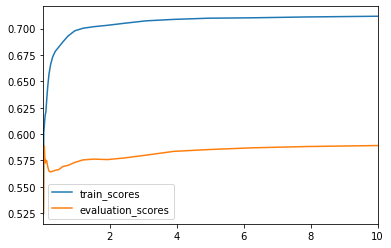

In [27]:
ds.plot()
print(ds.evaluation_scores.max())
print('---')
print(pd.Series(clf.best_estimator_.coef_[0], index=XtrainTrf.columns).abs().sort_values(ascending=False))
print('---')
print(clf.best_estimator_)

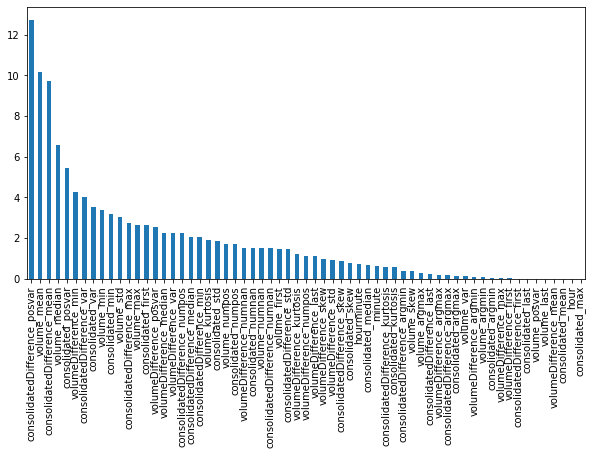

In [28]:
pd.Series(clf.best_estimator_.coef_[0], index=XtrainTrf.columns).abs().sort_values(ascending=False).plot.bar(figsize=(10,5));

# L2 regularization

In [29]:
C = 10**np.linspace(-5,2,100) 
grid_parameters = {
    'C': C,
    'class_weight': [class_weight],
    'penalty':['l2']
}

clf = GridSearchCV(LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=10000, C=C), grid_parameters, scoring='average_precision', cv=3, return_train_score=True)
clf.fit(XtrainTrf, ytrain);  
test_scores = clf.cv_results_['mean_test_score']
train_scores = clf.cv_results_['mean_train_score']
ds = pd.DataFrame({'train_scores':train_scores, 'evaluation_scores':test_scores}, index=C)

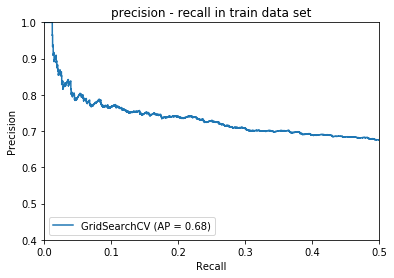

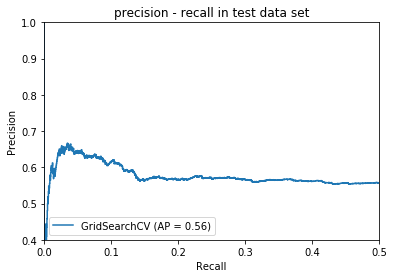

In [30]:
plot_precision_recall_on_train_and_test(clf, XtrainTrf, ytrain, XtestTrf, ytest)

0.598716457813902
---
consolidatedDifference_posvar    12.634619
volume_mean                      10.712054
consolidated_min                 10.120985
consolidatedDifference_mean       9.503602
volume_median                     6.983770
                                   ...    
consolidatedDifference_argmax     0.142536
volumeDifference_argmin           0.108208
volumeDifference_first            0.105392
volume_argmin                     0.086289
consolidated_argmin               0.045054
Length: 63, dtype: float64
---
LogisticRegression(C=100.0, class_weight={False: 1, True: 1}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


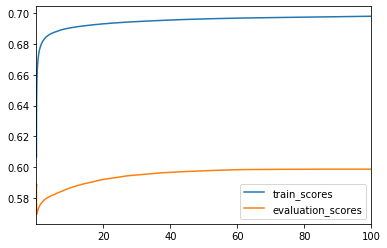

In [31]:
ds.plot()
print(ds.evaluation_scores.max())
print('---')
print(pd.Series(clf.best_estimator_.coef_[0], index=XtrainTrf.columns).abs().sort_values(ascending=False))
print('---')
print(clf.best_estimator_)

# Random Forest
* Horrible overift ... for now! ... unexpectedly hard to control !!

In [32]:
grid_parameters = {
    #'min_samples_leaf' : [100, 1000, 2000],
    'max_depth': [2, 3, 4, 5, 6, 7, 8,9, 10],
    'n_estimators': [5, 10, 100],   
    'max_features': ['sqrt', 0.1, 0.2, 0.5, 0.8]
}

clf = GridSearchCV(RandomForestClassifier(), grid_parameters, scoring='average_precision', cv=3, return_train_score=True)
clf.fit(XtrainTrf, ytrain);  
test_scores = clf.cv_results_['mean_test_score']
train_scores = clf.cv_results_['mean_train_score']
ds = pd.DataFrame({'train_scores':train_scores, 'evaluation_scores':test_scores})

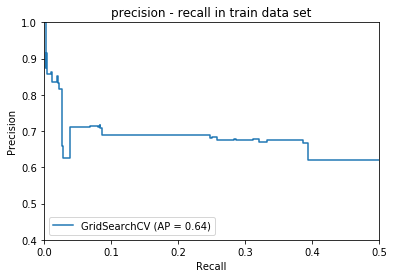

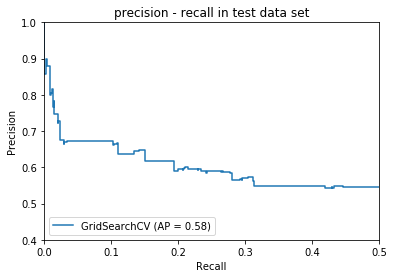

In [33]:
plot_precision_recall_on_train_and_test(clf, XtrainTrf, ytrain, XtestTrf, ytest)

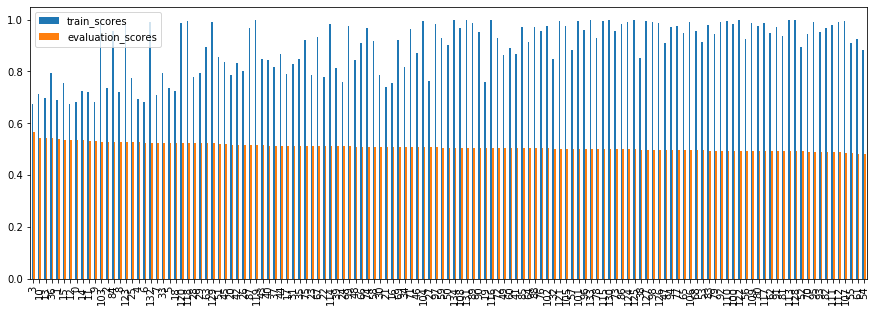

In [34]:
ds.sort_values(by='evaluation_scores', ascending=False).plot.bar(figsize=(15,5))

In [35]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features=0.1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

feature importance


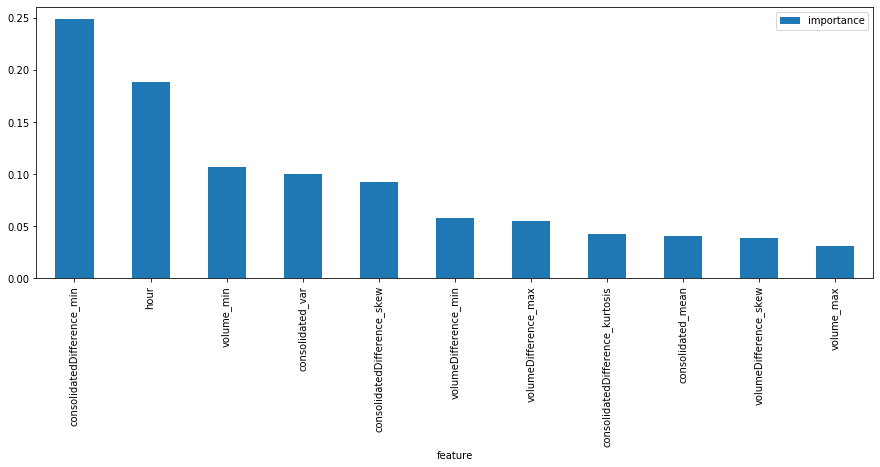

In [38]:
print("feature importance")
feature_importance = pd.DataFrame({'feature': XtrainTrf.columns, 'importance':clf.best_estimator_.feature_importances_}).set_index('feature').sort_values(by=['importance'], ascending=False)
feature_importance[feature_importance.importance>0].plot.bar(figsize=(15,5))